In [ ]:
# Imports
import numpy as np
import pandas as pd
# import dask.array as da
from skimage.measure import regionprops_table
import time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import feature_extraction as fe
import sparse

mask_path = '/net/beliveau/vol2/instrument/E9.5_290/Zoom_290_subset_test/dataset_fused_masks_cpsamr5.zarr'
n5_image_path = '/net/beliveau/vol2/instrument/E9.5_290/Zoom_290_subset_test/dataset_fused.n5'

def load_all_data(mask_path, 
                  n5_path, 
                  do_crop=False,
                  subset_size=None):
    # load mask and image data
    mask_da = fe.load_n5_zarr_array(mask_path)
    image_da = fe.load_n5_zarr_array(n5_path, n5_subpath='ch0/s0')

    if do_crop:
        crop_size = (800, 800, 800)  # z, y, x
        mask_da = mask_da[:crop_size[0], :crop_size[1], :crop_size[2]]
        image_da = image_da[:crop_size[0], :crop_size[1], :crop_size[2]]

    # convert to sparse
    chunk_shape = tuple(c[0] for c in mask_da.chunks)
    meta_block = sparse.COO.from_numpy(np.zeros(chunk_shape, 
                                                dtype=mask_da.dtype))
    mask_sparse = mask_da.map_blocks(
    fe.to_sparse,
    dtype=mask_da.dtype,
    meta=meta_block,
    chunks=mask_da.chunks
    )

    # find bounding boxes
    df_bboxes = fe.find_objects(mask_sparse).compute()
    df_bboxes = pd.DataFrame(df_bboxes)
    print(f"Found {len(df_bboxes)} objects")

    if subset_size is not None:
        obj_idxs = np.random.randint(0, 
                                     len(df_bboxes), 
                                     size=subset_size)
        test_objects = df_bboxes.iloc[obj_idxs]
        return mask_da, image_da, test_objects
    return mask_da, image_da 

mask_da, image_da, test_objects = load_all_data(mask_path=mask_path,
                                                n5_path=n5_image_path,
                                                do_crop=True,
                                                subset_size=10)

2025-07-02 14:13:08,146 - feature_extraction - INFO - --- Environment Versions ---
2025-07-02 14:13:08,147 - feature_extraction - INFO - Platform: Linux-5.15.0-119-generic-x86_64-with-glibc2.35
2025-07-02 14:13:08,147 - feature_extraction - INFO - Python: 3.13.3 | packaged by conda-forge | (main, Apr 14 2025, 20:44:03) [GCC 13.3.0]
2025-07-02 14:13:08,150 - feature_extraction - INFO - Dask: 2025.2.0
2025-07-02 14:13:08,152 - feature_extraction - INFO - Distributed: 2025.2.0
2025-07-02 14:13:08,153 - feature_extraction - INFO - Cloudpickle: 3.0.0
2025-07-02 14:13:08,153 - feature_extraction - INFO - Msgpack: 1.0.8
2025-07-02 14:13:08,154 - feature_extraction - INFO - Zarr: 2.13.3
2025-07-02 14:13:08,154 - feature_extraction - INFO - NumPy: 2.2.6
2025-07-02 14:13:08,156 - feature_extraction - INFO - Scikit-image: 0.25.0
2025-07-02 14:13:08,156 - feature_extraction - INFO - --- Dask Config (relevant parts) ---
2025-07-02 14:13:08,157 - feature_extraction - INFO - distributed.comm.compress

Found 976 objects


In [6]:
# 5. Define enhanced process_object function
import align_3d as align
import plot_utils
from importlib import reload
reload(align)
reload(plot_utils)

def process_object(obj, mask_da, image_da):
    """
    Enhanced process_object that includes spherical harmonics computation
    Args:
        obj: pandas.Series
            A row from the DataFrame containing the object bounding box coordinates
        mask_da: dask.array.Array
            The segmentation mask array (ZYX)
        image_da: dask.array.Array
            The input image array (ZYXC)
    Returns:
        final_dict: dict
            A dictionary containing the object properties and spherical harmonics coefficients
    """
    obj_id = int(obj.name)
    slice_z = obj[0]
    slice_y = obj[1] 
    slice_x = obj[2]

    # Compute centroid of object (in global coordinates)
    centroid_z = slice_z.start + (slice_z.stop - slice_z.start) // 2
    centroid_y = slice_y.start + (slice_y.stop - slice_y.start) // 2
    centroid_x = slice_x.start + (slice_x.stop - slice_x.start) // 2

    # Get only the pixels belonging to the object of interest
    label_slice = np.where(mask_da == obj_id, mask_da, 0)
    # Basic regionprops
    props = ["label", 
                "area", 
                "mean_intensity"]
    df_props = regionprops_table(label_slice, image_da, properties=props)
    if df_props['area'] < 500:
        return ValueError(f"Object {obj_id} too small. Skipping...")
    # Align object
    aligned_slice, df_props = align.align_object(label_slice, df_props)
    plot_utils.visualize_comparison(label_slice, aligned_slice)
    plot_utils.visualize(aligned_slice)
    return df_props


--- Processing object 1/10 - (label 594) ---
0    slice(393, 446, None)
1    slice(365, 393, None)
2    slice(639, 669, None)
Name: 594, dtype: object


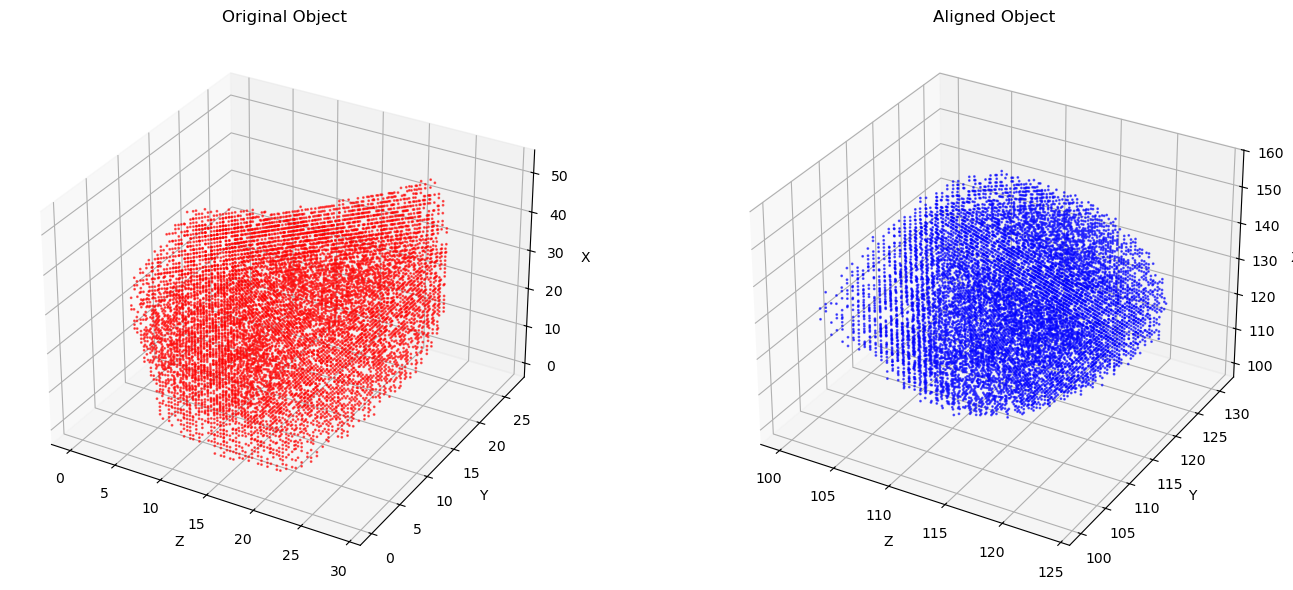

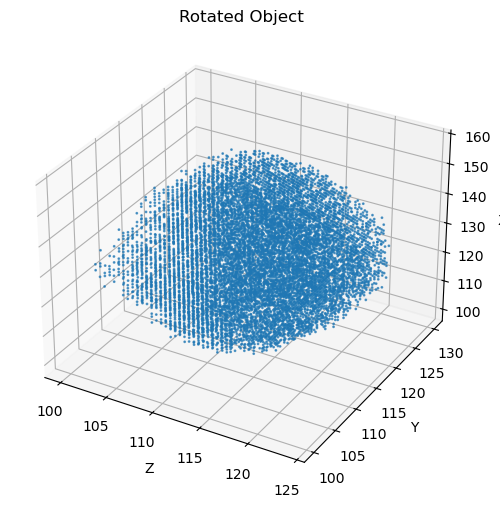

{'label': array([594]), 'area': array([18072.]), 'mean_intensity': array([1099.55583223]), 'major_magnitude': np.float64(56.633304470852444), 'intermediate_magnitude': np.float64(30.55296701906591), 'minor_magnitude': np.float64(24.2636881656587)}

--- Processing object 2/10 - (label 7653) ---
0    slice(580, 607, None)
1    slice(790, 800, None)
2    slice(435, 455, None)
Name: 7653, dtype: object


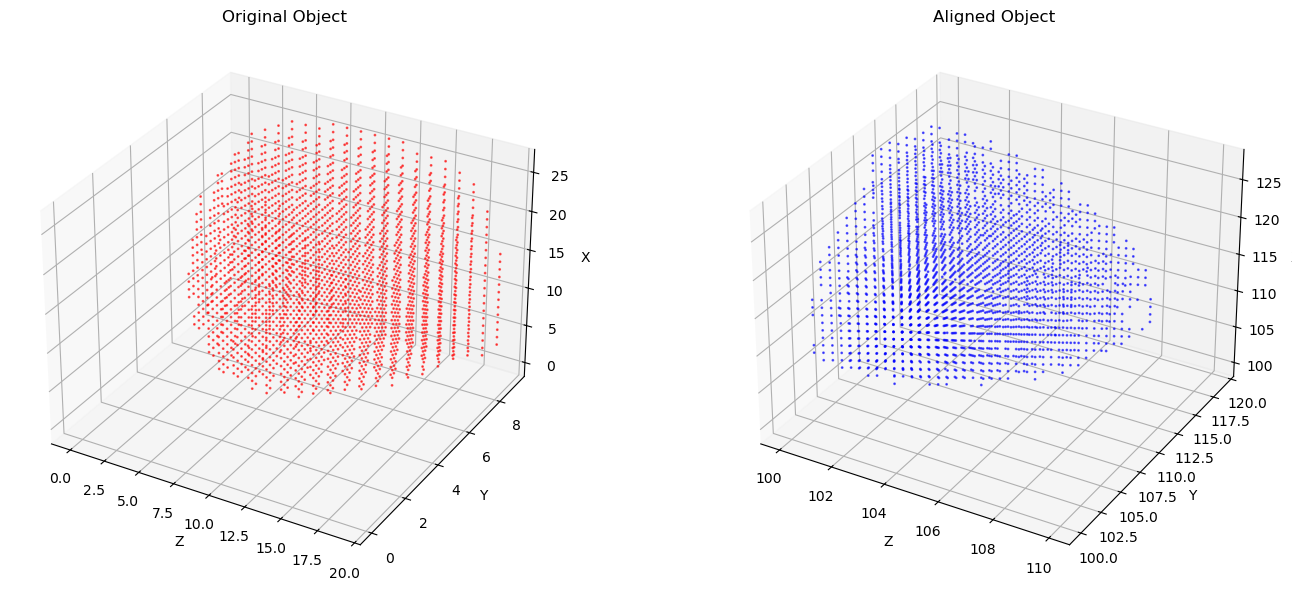

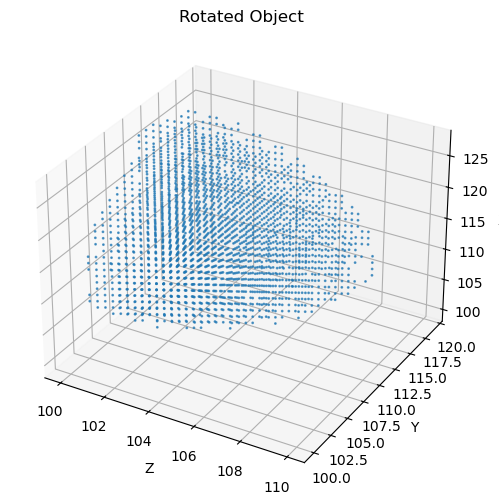

{'label': array([7653]), 'area': array([2549.]), 'mean_intensity': array([637.24597882]), 'major_magnitude': np.float64(27.176274163347518), 'intermediate_magnitude': np.float64(19.149534539705225), 'minor_magnitude': np.float64(9.556418599620345)}

--- Processing object 3/10 - (label 459) ---
0    slice(215, 256, None)
1    slice(358, 392, None)
2    slice(606, 645, None)
Name: 459, dtype: object


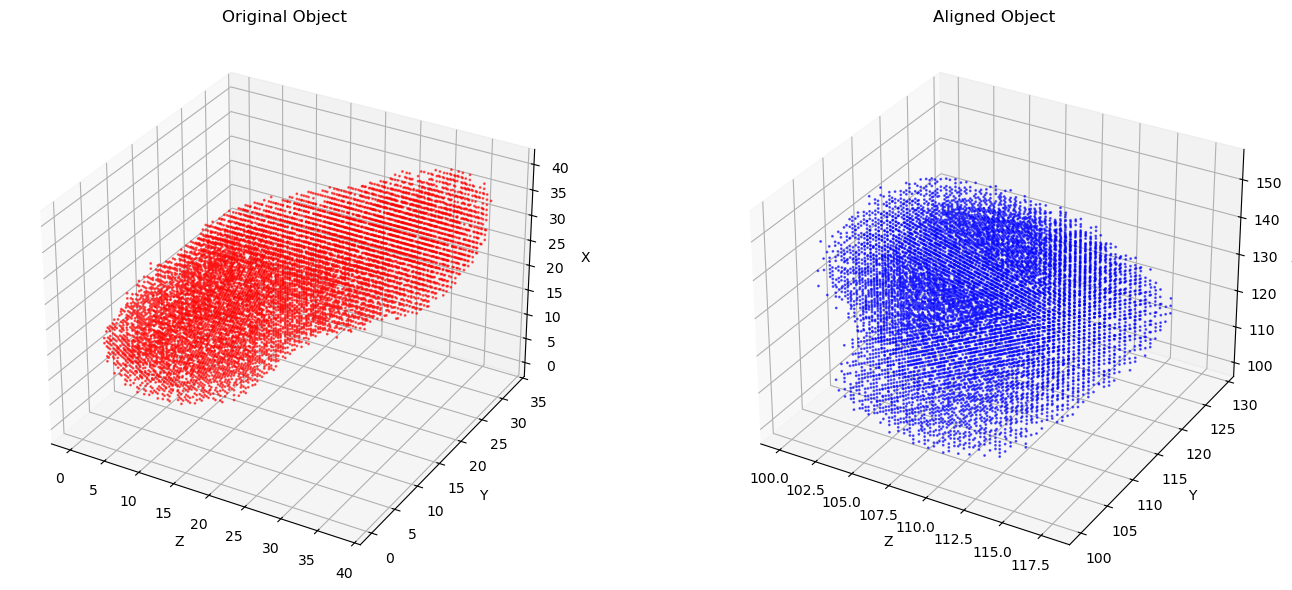

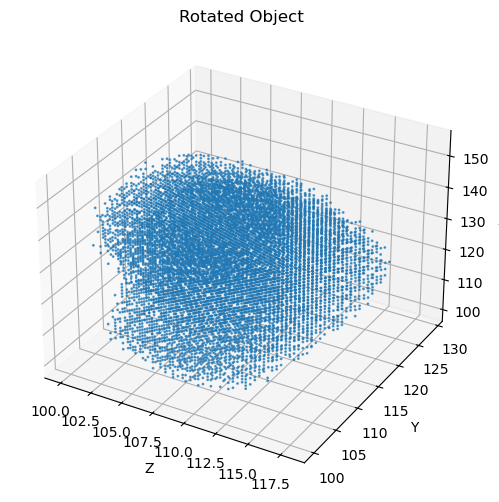

{'label': array([459]), 'area': array([13667.]), 'mean_intensity': array([1371.44962318]), 'major_magnitude': np.float64(54.174899444443405), 'intermediate_magnitude': np.float64(29.340005978511208), 'minor_magnitude': np.float64(18.404273928668474)}

--- Processing object 4/10 - (label 454) ---
0    slice(210, 250, None)
1    slice(490, 528, None)
2    slice(606, 638, None)
Name: 454, dtype: object


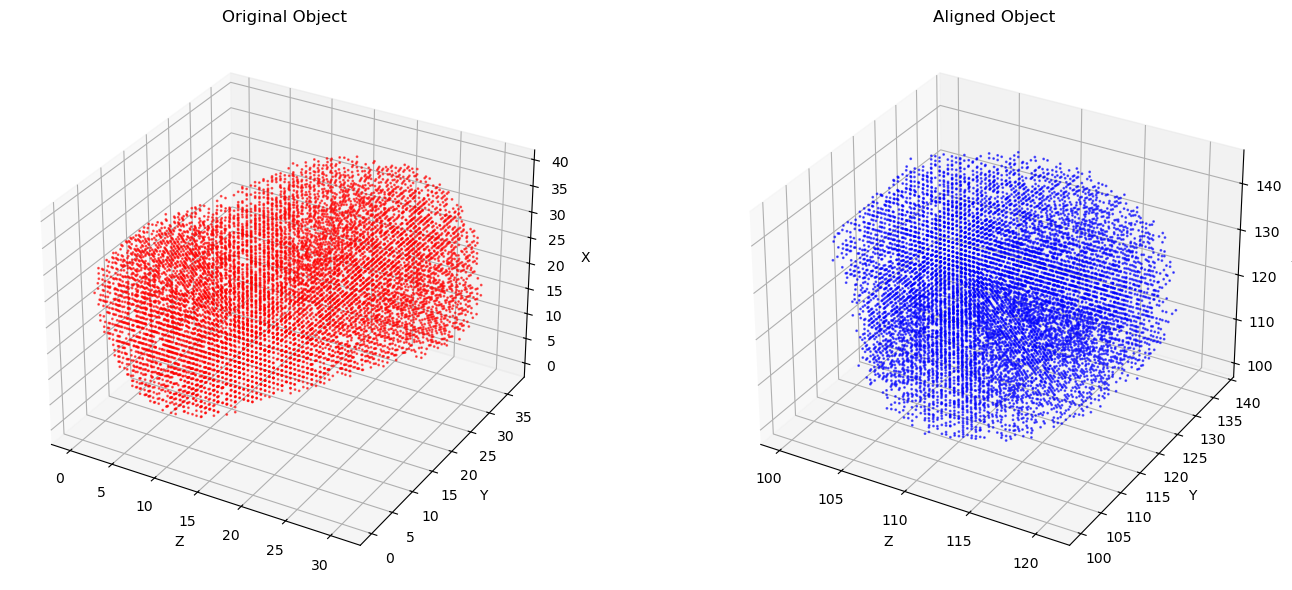

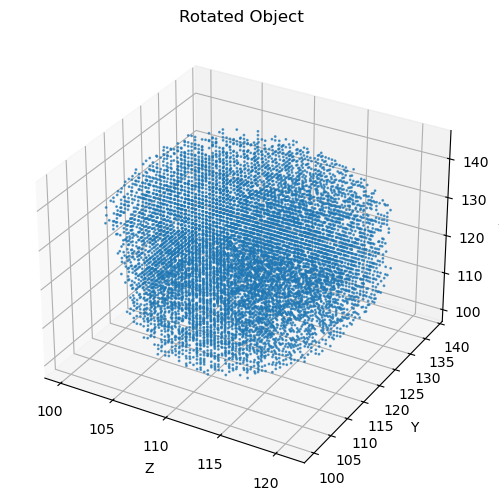

{'label': array([454]), 'area': array([20751.]), 'mean_intensity': array([3720.13777649]), 'major_magnitude': np.float64(44.45266078072183), 'intermediate_magnitude': np.float64(38.22350873439768), 'minor_magnitude': np.float64(21.417379977125147)}

--- Processing object 5/10 - (label 213) ---
0    slice(473, 517, None)
1    slice(172, 215, None)
2    slice(224, 265, None)
Name: 213, dtype: object


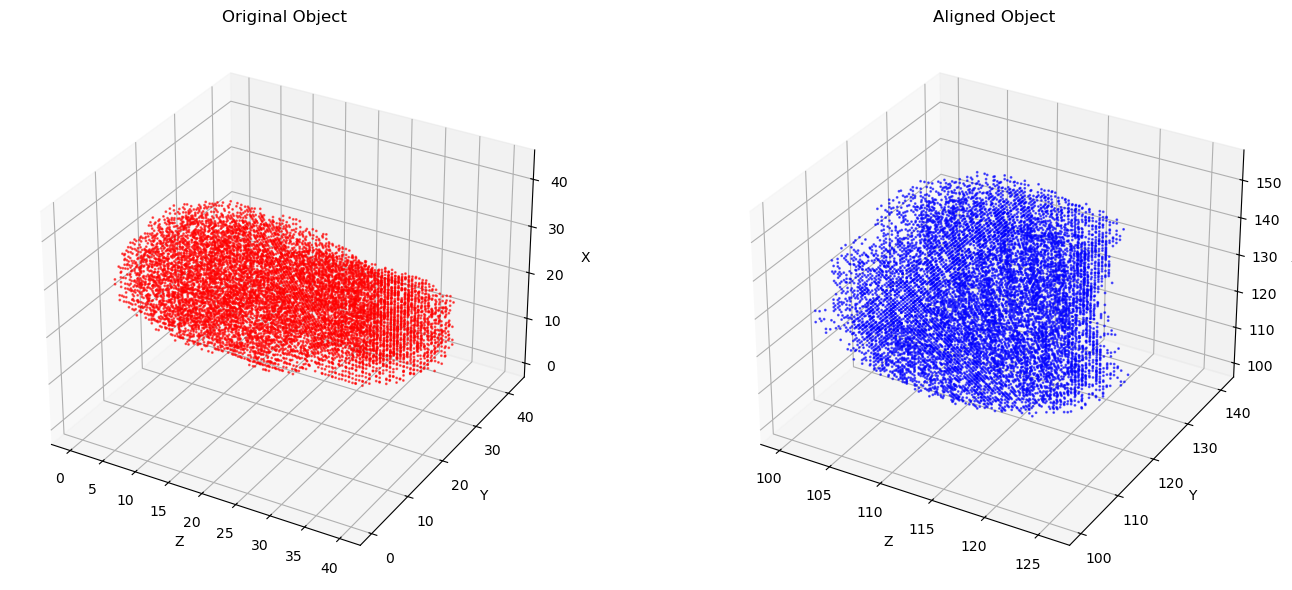

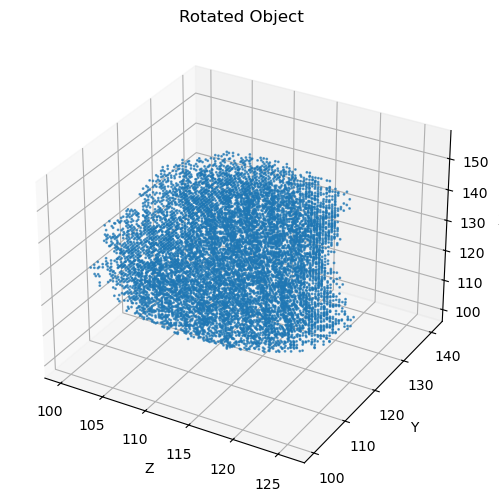

{'label': array([213]), 'area': array([24792.]), 'mean_intensity': array([1566.74177154]), 'major_magnitude': np.float64(54.509407388568945), 'intermediate_magnitude': np.float64(40.93783832928893), 'minor_magnitude': np.float64(25.919263410195253)}

--- Processing object 6/10 - (label 5686) ---
0    slice(639, 684, None)
1    slice(329, 354, None)
2    slice(160, 183, None)
Name: 5686, dtype: object


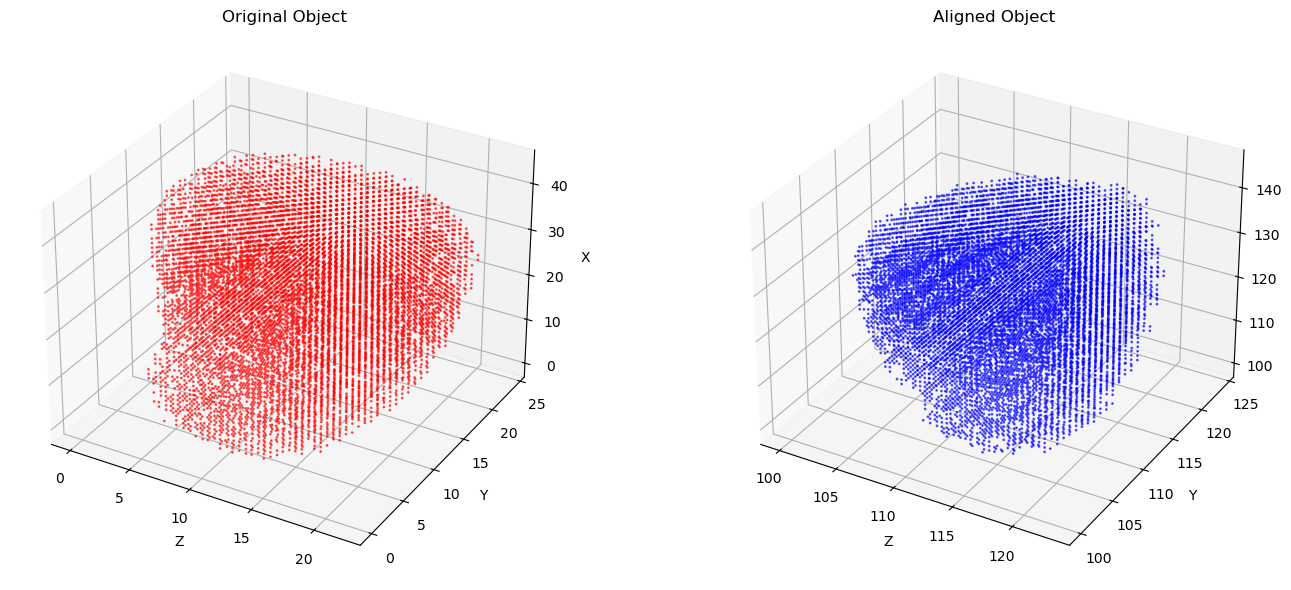

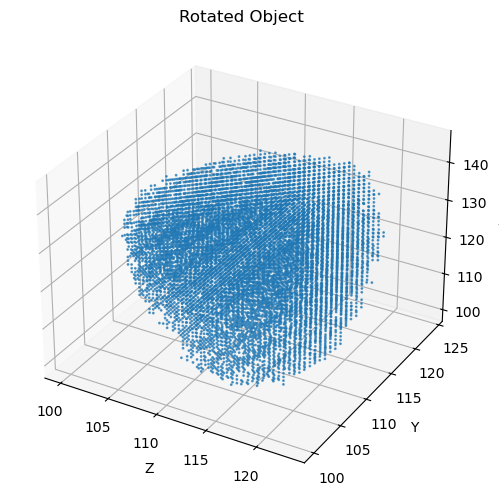

{'label': array([5686]), 'area': array([13318.]), 'mean_intensity': array([989.21226911]), 'major_magnitude': np.float64(45.39563777415615), 'intermediate_magnitude': np.float64(24.275346677564656), 'minor_magnitude': np.float64(23.289365086103718)}

--- Processing object 7/10 - (label 5790) ---
0    slice(785, 800, None)
1     slice(79, 113, None)
2    slice(219, 241, None)
Name: 5790, dtype: object


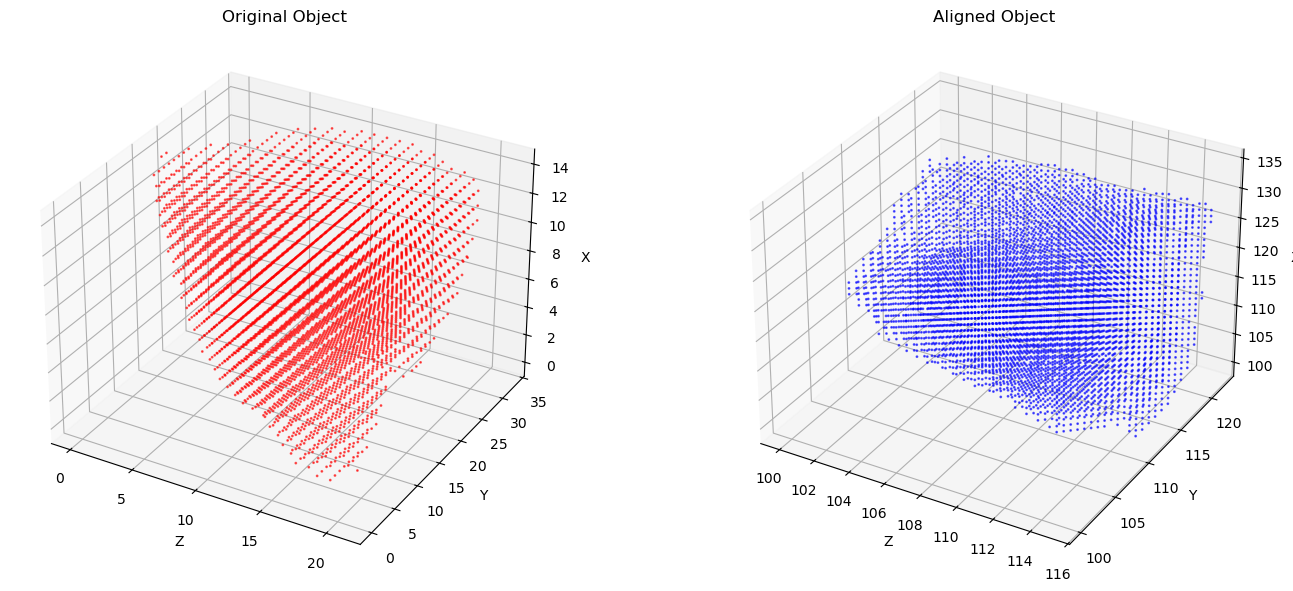

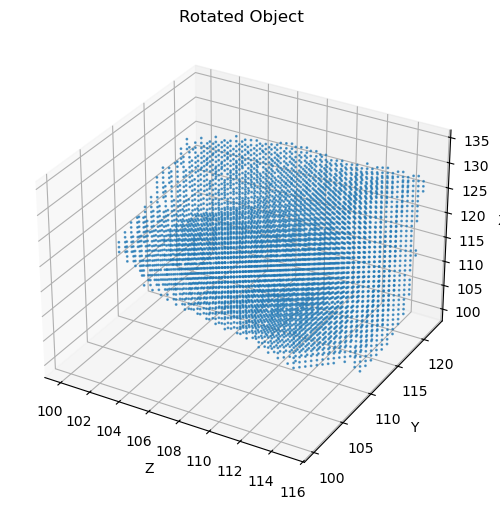

{'label': array([5790]), 'area': array([5909.]), 'mean_intensity': array([4924.21441868]), 'major_magnitude': np.float64(33.53897998326275), 'intermediate_magnitude': np.float64(21.86961491909015), 'minor_magnitude': np.float64(15.36211965471017)}

--- Processing object 8/10 - (label 3019) ---
0    slice(469, 508, None)
1    slice(541, 568, None)
2    slice(270, 296, None)
Name: 3019, dtype: object


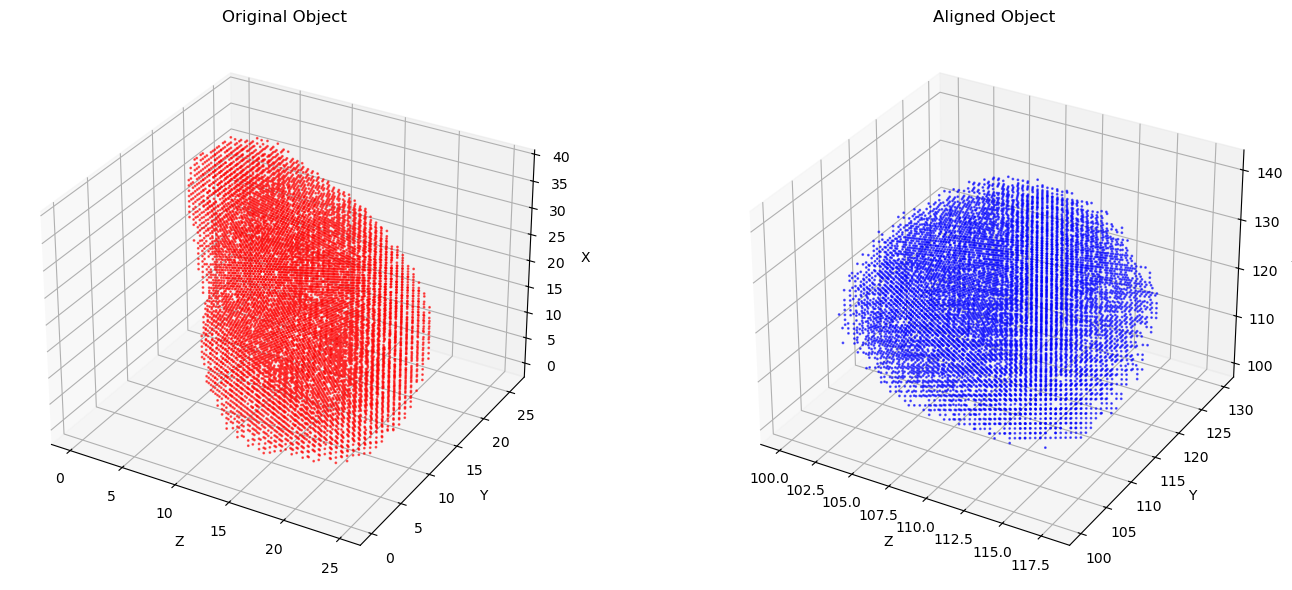

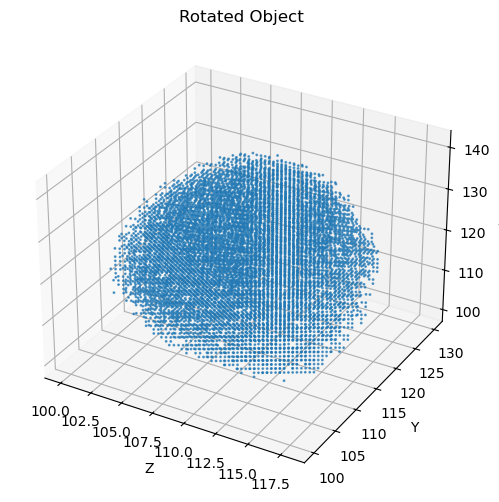

{'label': array([3019]), 'area': array([11386.]), 'mean_intensity': array([549.55875637]), 'major_magnitude': np.float64(41.269330401700564), 'intermediate_magnitude': np.float64(29.94398791680363), 'minor_magnitude': np.float64(17.716518697665304)}

--- Processing object 9/10 - (label 5659) ---
0    slice(607, 651, None)
1    slice(411, 434, None)
2    slice(149, 171, None)
Name: 5659, dtype: object


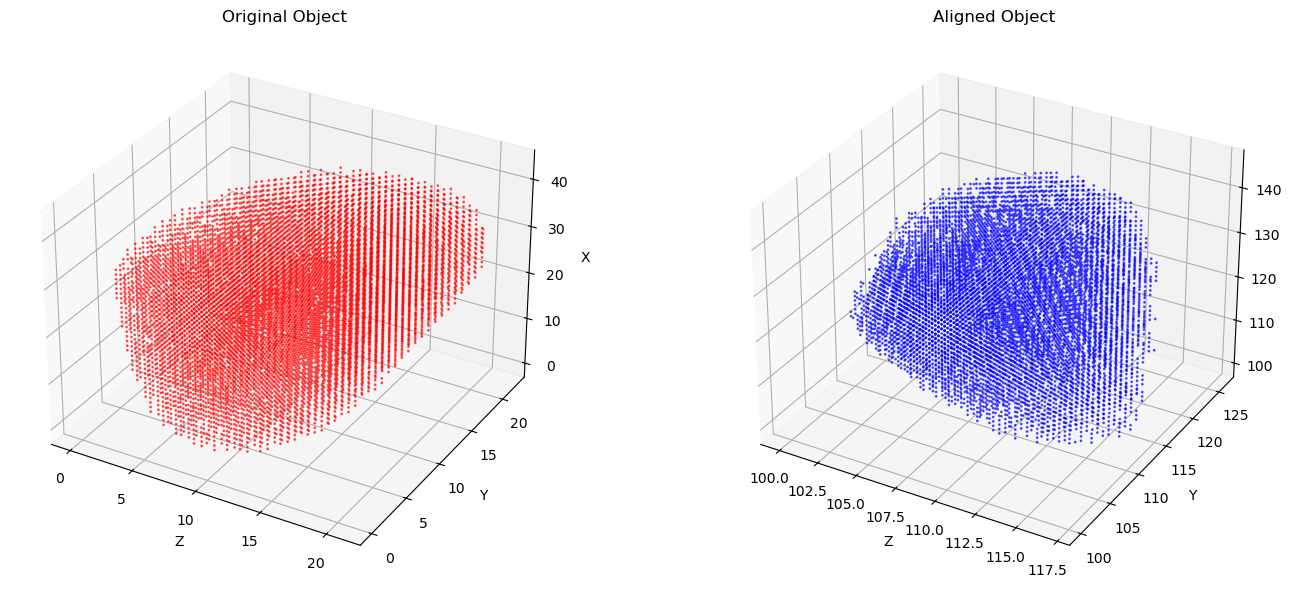

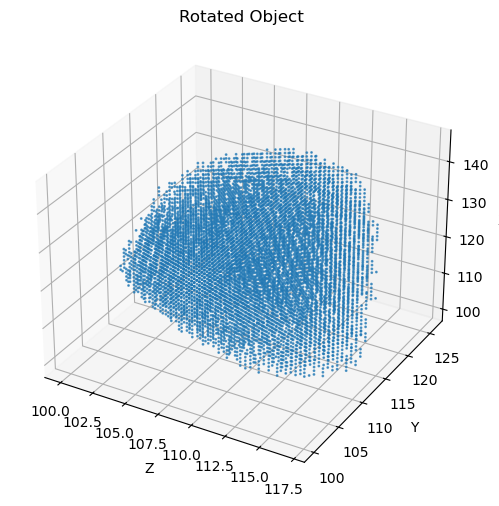

{'label': array([5659]), 'area': array([10233.]), 'mean_intensity': array([794.27108375]), 'major_magnitude': np.float64(44.645093594438904), 'intermediate_magnitude': np.float64(25.704416651150915), 'minor_magnitude': np.float64(16.954458153004364)}

--- Processing object 10/10 - (label 7643) ---
0    slice(541, 578, None)
1    slice(584, 631, None)
2    slice(181, 207, None)
Name: 7643, dtype: object


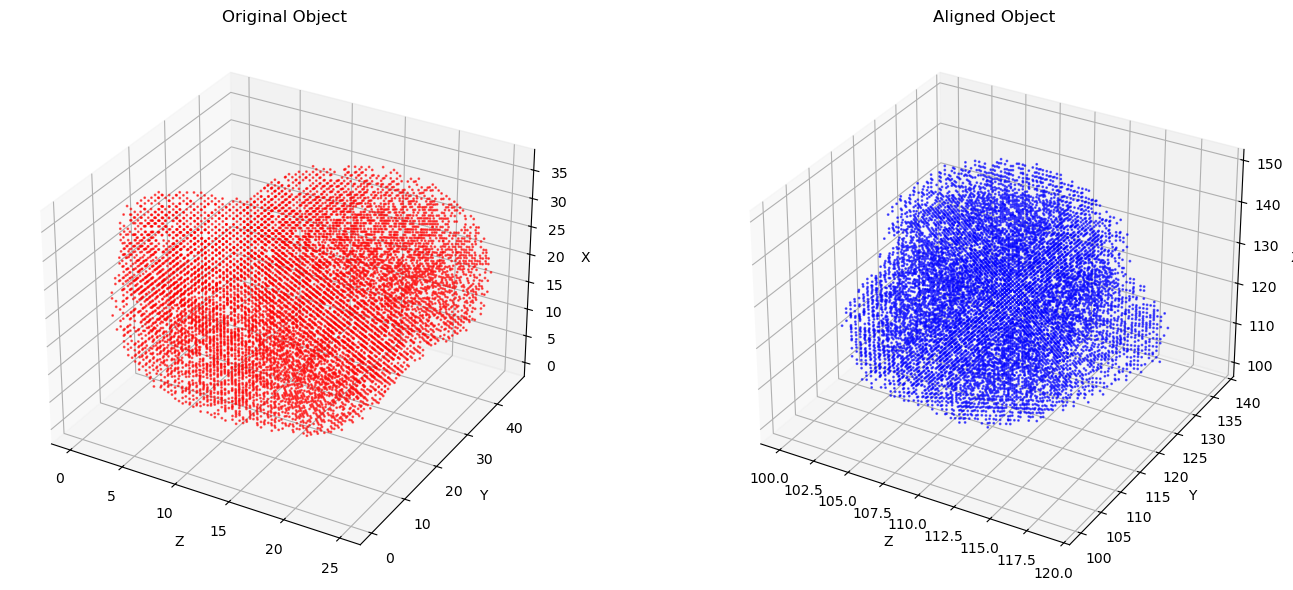

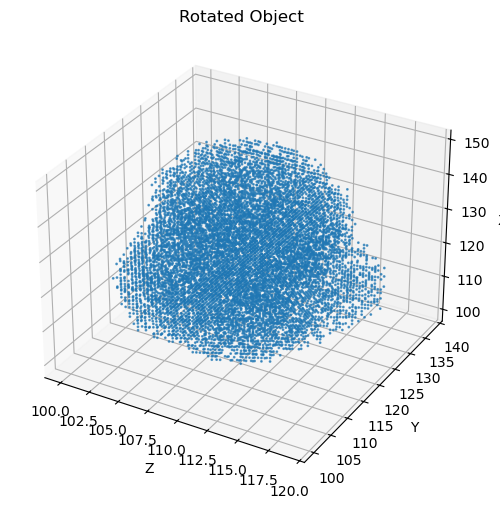

{'label': array([7643]), 'area': array([17065.]), 'mean_intensity': array([868.41043071]), 'major_magnitude': np.float64(48.96919985009944), 'intermediate_magnitude': np.float64(37.898088807803475), 'minor_magnitude': np.float64(18.92836881249411)}


In [7]:
results = []
i = 1
for idx, obj in test_objects.iterrows():
    print(f"\n--- Processing object {i}/{len(test_objects)} - (label {idx}) ---")
    i += 1
    # Extract bounding box
    slice_z, slice_y, slice_x = obj[0], obj[1], obj[2]
    bboxes = tuple([slice_z, slice_y, slice_x])    
    # Crop mask and image to bounding box
    mask_da_obj = mask_da[slice_z, slice_y, slice_x].compute()
    image_da_obj = image_da[slice_z, slice_y, slice_x].compute()
    # Process object
    obj_series = pd.Series(obj, name=idx)  # Create series with object ID as name
    print(obj_series)
    result = process_object(obj_series, mask_da_obj, image_da_obj)
    print(result)